In [1]:
import ee

In [2]:
ee.Authenticate()
ee.Initialize()


Successfully saved authorization token.


In [3]:
import requests

geoJSON 링크:

http://geojson.io/#map=2/20/0

링크에서 원하는 지역을 POLYGON으로 설정하여 다음 셀에서 geoJSON 설정

In [4]:
geoJSON = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              125.40634075130396,
              38.73471785836824
            ],
            [
              125.40634075130396,
              38.72222262176038
            ],
            [
              125.42408342571906,
              38.72222262176038
            ],
            [
              125.42408342571906,
              38.73471785836824
            ],
            [
              125.40634075130396,
              38.73471785836824
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}

In [5]:
coords = geoJSON['features'][0]['geometry']['coordinates']
aoi = ee.Geometry.Polygon(coords)

In [6]:
im_coll = (ee.ImageCollection('COPERNICUS/S1_GRD_FLOAT')
                .filterBounds(aoi)
                .filterDate(ee.Date('2018-03-07'),ee.Date('2022-07-20'))
                #.filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
                #.filter(ee.Filter.eq('relativeOrbitNumber_start', 127))
                #.filter(ee.Filter.eq('sliceNumber', 1))
                .sort('system:time_start'))

In [7]:
import time
acq_times = im_coll.aggregate_array('system:time_start').getInfo()
date = [time.strftime('%x', time.gmtime(acq_time/1000)) for acq_time in acq_times]

In [8]:
im_list = im_coll.toList(im_coll.size())

In [12]:
im_list.get(0).getInfo()
#im_list.getInfo()

{'type': 'Image',
 'bands': [{'id': 'VV',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [28828, 22538],
   'crs': 'EPSG:32651',
   'crs_transform': [10, 0, 451645.95050068066, 0, -10, 4479445.776226749]},
  {'id': 'VH',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [28828, 22538],
   'crs': 'EPSG:32651',
   'crs_transform': [10, 0, 451645.95050068066, 0, -10, 4479445.776226749]},
  {'id': 'angle',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [21, 10],
   'crs': 'EPSG:32651',
   'crs_transform': [-12680.793405561126,
    -3092.0677081955364,
    734545.7848111594,
    2029.9345224844292,
    -20167.661805022508,
    4435280.610619651]}],
 'id': 'COPERNICUS/S1_GRD_FLOAT/S1B_IW_GRDH_1SDV_20180307T214714_20180307T214741_009931_011FCC_B017',
 'version': 1545271362721848,
 'properties': {'SNAP_Graph_Processing_Framework_GPF_vers': '6.0.4',
  'SLC_Processing_facility_org': 'ESA',
  'SLC_Processing

In [13]:
len(date)

347

In [16]:
# Import the Folium library.
import folium

# Define a method for displaying Earth Engine image tiles to folium map.
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  folium.raster_layers.TileLayer(
    tiles = map_id_dict['tile_fetcher'].url_format,
    attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
    name = name,
    overlay = True,
    control = True
  ).add_to(self)

# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

In [17]:
im1 = ee.Image(im_list.get(1)).select('VV').clip(aoi)
im2 = ee.Image(im_list.get(2)).select('VV').clip(aoi)

location = aoi.centroid().coordinates().getInfo()[::-1]
mp = folium.Map(location=location, zoom_start=10)
mp.add_ee_layer(im1,{'min': 0, 'max': 1, 'palette': ['black', 'white']}, 'GRD_FLOAT')
mp.add_ee_layer(im2,{'min': 0, 'max': 1, 'palette': ['black', 'white']}, 'GRD_FLOAT2')
mp.add_child(folium.LayerControl())

display(mp)

In [45]:
# Multi-band GeoTIFF file.

for i in range(0, len(date)):
    url = ee.Image(im_list.get(i)).getDownloadUrl({
        'bands': ['VV', 'VH'],
        'region': aoi,
        'scale': 20,
        'format': 'GEO_TIFF'
    })
    response = requests.get(url) #아래 저장 경로설정하고 그 뒤에 저장할 파일명.tif
    with open('/home/jovyan/dltmdwns/ChangeDetection/S1A_GRD_' '20'+date[i][6:]+date[i][0:2]+date[i][3:5] +'.tif', 'wb') as fd:
      fd.write(response.content)

In [54]:
import rasterio
import matplotlib.pyplot as plt
import numpy as np

In [58]:
image = rasterio.open('/home/jovyan/dltmdwns/ChangeDetection/S1A_GRD_20220809.tif').read(1)

Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


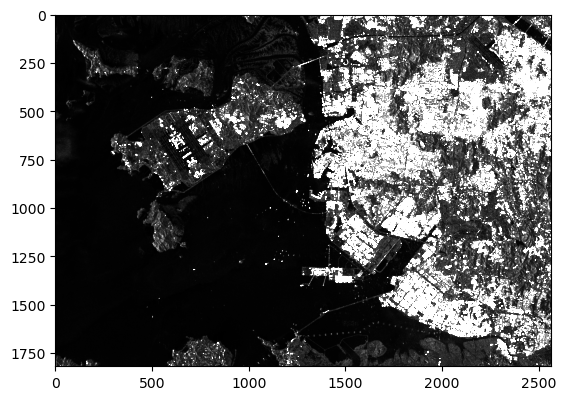

In [59]:
fig = plt.imshow(np.array(image), cmap = 'gray')
fig.set_clim(0, 1)
plt.show()